1. Reference implementation of node2vec. 
Author: Aditya Grover
For more details, refer to the paper:
node2vec: Scalable Feature Learning for Networks
Aditya Grover and Jure Leskovec 
Knowledge Discovery and Data Mining (KDD), 2016

2. Reference implementation of link prediction task using fb data: Lucas Hu https://github.com/lucashu1

In [2]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sp
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import pickle
from gae.preprocessing import mask_test_edges
import node2vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.linear_model import LogisticRegression    
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.metrics import recall_score, classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE

# Preprocessing

In [3]:
# Load pickled (adj, feat) tuple
network_dir = '0-adj-feat.pkl'
with open(network_dir, 'rb') as f:
    adj, features = pickle.load(f)

g = nx.Graph(adj)

/Users/m102853/anaconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


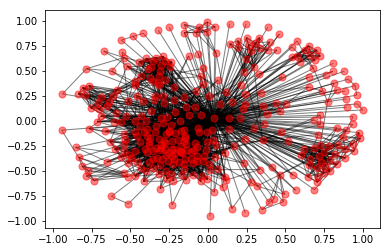

In [4]:
# visualize network
#plt.figure(figsize=(16,16)) # set up canvas size
nx.draw_networkx(g, alpha=0.5,with_labels=False, node_size=50, node_color='r')
plt.show()
%matplotlib inline

In [5]:
# Train Test spliting
np.random.seed(0) # make sure train-test split is consistent between notebooks

adj_sparse = nx.to_scipy_sparse_matrix(g)

adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj_sparse, test_frac=.3, val_frac=.1)

g_train = nx.from_scipy_sparse_matrix(adj_train) 

print ("Total nodes:", adj_sparse.shape[0])
print ("Total edges:", int(adj_sparse.nnz/2)) # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print ("Training edges (positive):", len(train_edges))
print ("Training edges (negative):", len(train_edges_false))
print ("Validation edges (positive):", len(val_edges))
print ("Validation edges (negative):", len(val_edges_false))
print ("Test edges (positive):", len(test_edges))
print ("Test edges (negative):", len(test_edges_false))

Total nodes: 348
Total edges: 2866
Training edges (positive): 1721
Training edges (negative): 1721
Validation edges (positive): 286
Validation edges (negative): 286
Test edges (positive): 859
Test edges (negative): 859


# Learning Node Embeddings

In [6]:
# Node2vec

P = 1 # Return hyperparameter
Q = 0.25 # In-out hyperparameter
WINDOW_SIZE = 10 # Context size for optimization
NUM_WALKS = 10 # Number of walks per source
WALK_LENGTH = 80 # Length of walk per source
DIMENSIONS = 128 # Embedding dimension
DIRECTED = False # Graph directed/undirected
WORKERS = 8 # Num. parallel workers
ITER = 1 # SGD epochs

# Preprocessing, generate walks
g_n2v = node2vec.Graph(g_train, DIRECTED, P, Q)
g_n2v.preprocess_transition_probs()
walks = g_n2v.simulate_walks(NUM_WALKS, WALK_LENGTH)

#walks = [map(str, walk) for walk in walks]  #### python2
walks = [list(map(str, walk)) for walk in walks] #### python3

# Train skip-gram model
model = Word2Vec(walks, size=DIMENSIONS, window=WINDOW_SIZE, 
                 min_count=0, sg=1, workers=WORKERS, iter=ITER)

# Store embeddings mapping
emb_mappings = model.wv

model.wv.save_word2vec_format('fb_test.emd')


Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


# Visualizing Node Embeddings

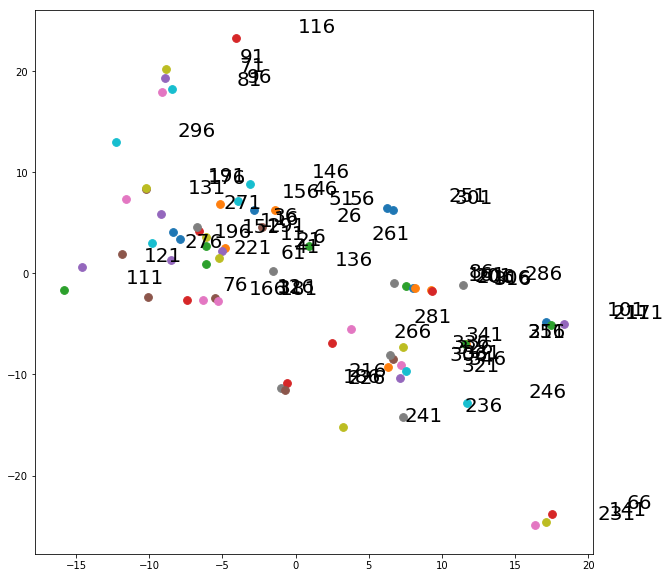

In [7]:
X = []
y = []

# Open embedding file
with open('fb_test.emd') as f:
    next(f)
    for line in f:
        splits = line.strip().split()
        label = splits[0]
        vec = [float(v) for v in splits[1:]]

        X.append(vec)
        y.append(label)

np.random.seed(0)

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10,10))

for i in range(1, len(X), 5):
        plt.scatter(X_tsne[i, 0], X_tsne[i, 1],s=60)
        plt.annotate(str(i),
                     xy=(X_tsne[i, 0], X_tsne[i, 1]),
                     xytext=(100, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',fontsize=20)

plt.show()      

# Similarity Measurement

In [8]:
s1 = emb_mappings.similarity('156', '316')

print(s1)

0.7011056509017692


In [11]:
s2 = emb_mappings.most_similar('156')

print(s2)

[('200', 0.9777733683586121), ('260', 0.9730045795440674), ('240', 0.9677531123161316), ('212', 0.9643835425376892), ('158', 0.9643402099609375), ('281', 0.9634730219841003), ('246', 0.9618453979492188), ('157', 0.9590436220169067), ('148', 0.9548705816268921), ('247', 0.9499093890190125)]
